In [42]:
from pathlib import Path
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import relativedelta
from collections import defaultdict
from sklearn.metrics import (
    average_precision_score, 
    log_loss, 
    roc_auc_score, 
    auc, 
    precision_recall_curve, 
    roc_curve
)
from xgboost import XGBClassifier
import xgboost as xgb
import shap
from typing import Tuple

In [43]:
pd.set_option('display.max_columns', None)

In [44]:
data_path = Path("../data")

In [45]:
df = pd.read_parquet(data_path / "full_data.parquet")

In [46]:
column_order = [
    'advertiser_zrive_id',
    'period_int',
    'monthly_published_ads',
    'monthly_published_ads_3_months_mean',
    'monthly_published_ads_3_months_mean_delta',
    'monthly_unique_published_ads',
    'monthly_contracted_ads',
    'monthly_contracted_ads_3_months_mean',
    'monthly_contracted_ads_3_months_mean_delta',
    'monthly_leads',
    'monthly_leads_3_months_mean',
    'monthly_leads_3_months_mean_delta',
    'monthly_visits',
    'monthly_visits_3_months_mean',
    'monthly_visits_3_months_mean_delta',
    'monthly_oro_ads',
    'monthly_plata_ads',
    'monthly_destacados_ads',
    'monthly_pepitas_ads',
    'monthly_shows',
    'monthly_total_phone_views',
    'monthly_total_calls',
    'monthly_total_emails',
    'monthly_total_invoice',
    'monthly_total_invoice_3_months_mean',
    'monthly_total_invoice_3_months_mean_delta',
    'monthly_unique_calls',
    'monthly_unique_emails',
    'monthly_unique_leads',
    'monthly_avg_ad_price',
    'monthly_avg_ad_price_3_months_mean',
    'monthly_avg_ad_price_3_months_mean_delta',
    'monthly_distinct_ads',
    'month_period',
    'tenure',
    'months_since_last_contract',
    'has_renewed',
    'monthly_total_premium_ads',
    'ratio_published_contracted',
    'ratio_published_contracted_3_months_mean',
    'ratio_published_contracted_3_months_mean_delta',
    'ratio_unique_published',
    'ratio_unique_published_3_months_mean',
    'ratio_unique_published_3_months_mean_delta',
    'ratio_premium_ads',
    'ratio_premium_ads_3_months_mean',
    'ratio_premium_ads_3_months_mean_delta',
    'leads_per_published_ad',
    'leads_per_published_ad_3_months_mean',
    'leads_per_published_ad_3_months_mean_delta',
    'leads_per_premium_ad',
    'leads_per_premium_ad_3_months_mean',
    'leads_per_premium_ad_3_months_mean_delta',
    'visits_per_published_ad',
    'visits_per_published_ad_3_months_mean',
    'visits_per_published_ad_3_months_mean_delta',
    'leads_per_visit',
    'leads_per_visit_3_months_mean',
    'leads_per_visit_3_months_mean_delta',
    'leads_per_shows',
    'leads_per_shows_3_months_mean',
    'leads_per_shows_3_months_mean_delta',
    'invoice_per_published_ad',
    'invoice_per_published_ad_3_months_mean',
    'invoice_per_published_ad_3_months_mean_delta',
    'invoice_per_lead',
    'invoice_per_lead_3_months_mean',
    'invoice_per_lead_3_months_mean_delta',
    'churn'
]

df = df[column_order]
df['churn'] = df['churn'].astype(int)

In [47]:
df = df.drop(['monthly_distinct_ads', 'monthly_avg_ad_price', 'monthly_avg_ad_price_3_months_mean', 'monthly_avg_ad_price_3_months_mean_delta' ], axis=1)

In [48]:
ids_with_nan = df[
    df['tenure'].isna() | df['months_since_last_contract'].isna()
]['advertiser_zrive_id'].unique()

df = df[~df['advertiser_zrive_id'].isin(ids_with_nan)]

In [49]:
info_cols = ['advertiser_zrive_id', 'period_int', 'month_period']
label_col = 'churn'
features_cols = [col for col in df.columns if col not in info_cols + [label_col]]


binary_cols = ['has_renewed']
numerical_cols = [col for col in features_cols if col not in  binary_cols]

In [50]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

In [51]:
train_cols = numerical_cols + binary_cols

In [52]:
import pandas as pd
import re
import numpy as np
from xgboost import XGBClassifier
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip, geom_bar,scale_x_discrete, geom_point, theme,element_text, geom_boxplot, coord_cartesian, scale_color_manual

In [53]:
def split_train_test_by_period(data_set, execution_date):
    train_end_date = execution_date + relativedelta(months=6)
    val_date = execution_date + relativedelta(months=7)

    train_start_str = execution_date.strftime('%Y%m')
    train_end_str = train_end_date.strftime('%Y%m')
    val_str = val_date.strftime('%Y%m')

    train_set = data_set[
        (data_set['month_period'] >= train_start_str) &
        (data_set['month_period'] <= train_end_str)
    ]
    test_set = data_set[data_set['month_period'] == val_str]

    return train_set, test_set

In [54]:
import warnings
warnings.filterwarnings('ignore')

def train_model(X_train, X_test, n_estimators=300):
    y_train = X_train["churn"]
    y_test = X_test["churn"]

    X_train["month_period"] = X_train["month_period"].astype("category").cat.codes
    X_test["month_period"] = X_test["month_period"].astype("category").cat.codes

    dtrain = xgb.DMatrix(X_train.drop(columns="churn"), label=y_train)
    dtest = xgb.DMatrix(X_test.drop(columns="churn"), label=y_test)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "seed": 1,
        "nthread": 10,
    }

    evals_result = {}
    evals = [(dtest, "eval"), (dtrain, "train")]

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=n_estimators,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False
    )

    return model, evals_result, X_train, X_test

In [55]:
def run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, n_estimators):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(df, execution_date)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None

        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)

            dtest = xgb.DMatrix(X_test.drop(columns=["churn"], errors="ignore"))
            test_set['prob'] = model.predict(dtest)

            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)

        return all_results, all_predicted_tickers_list, all_models, model, X_train, X_test

In [56]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": 'binary',
    "metric": 'binary_logloss',
    "n_estimators": 40
}

In [57]:
def train_model_across_periods(n_estimators):
    global all_results
    global all_predicted_tickers_list
    global all_models
    global all_predicted_tickers

    start_date = datetime.datetime(2023, 3, 1)
    end_date = datetime.datetime(2024, 11, 1)
    current_date = start_date

    while current_date + relativedelta(months=7) <= end_date:
        print(current_date)
        all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(
            current_date, all_results, all_predicted_tickers_list, all_models, n_estimators
        )

        current_date += relativedelta(months=1)

    all_predicted_tickers = pd.concat(all_predicted_tickers_list)

train_model_across_periods(n_estimators=params["n_estimators"])

2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00


In [58]:
def return_learning_curve(set_name):
    learning_curves = pd.DataFrame()
    for date in all_results:
        learning_curve = pd.DataFrame(all_results[date][set_name])
        learning_curve["n_trees"] = list(range(len(learning_curve)))
        learning_curve["execution_date"] = date
        learning_curves = pd.concat([learning_curves, learning_curve])

    for column in learning_curves.columns:
        if column not in ["n_trees", "execution_date"]:
            first_metric = learning_curves[[column, "execution_date"]].drop_duplicates(['execution_date'])
            first_metric = first_metric.rename(columns={column: "first_" + column})
            learning_curves = pd.merge(learning_curves, first_metric, on=["execution_date"])
            learning_curves["norm_" + column] = (learning_curves[column] - learning_curves["first_" + column]) / learning_curves["first_" + column]
            learning_curves = learning_curves.drop(columns="first_" + column)
    learning_curves["execution_date"] = learning_curves["execution_date"].astype(str)

    return learning_curves

In [59]:
test_lc = return_learning_curve("eval")
train_lc = return_learning_curve("train")

In [60]:
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

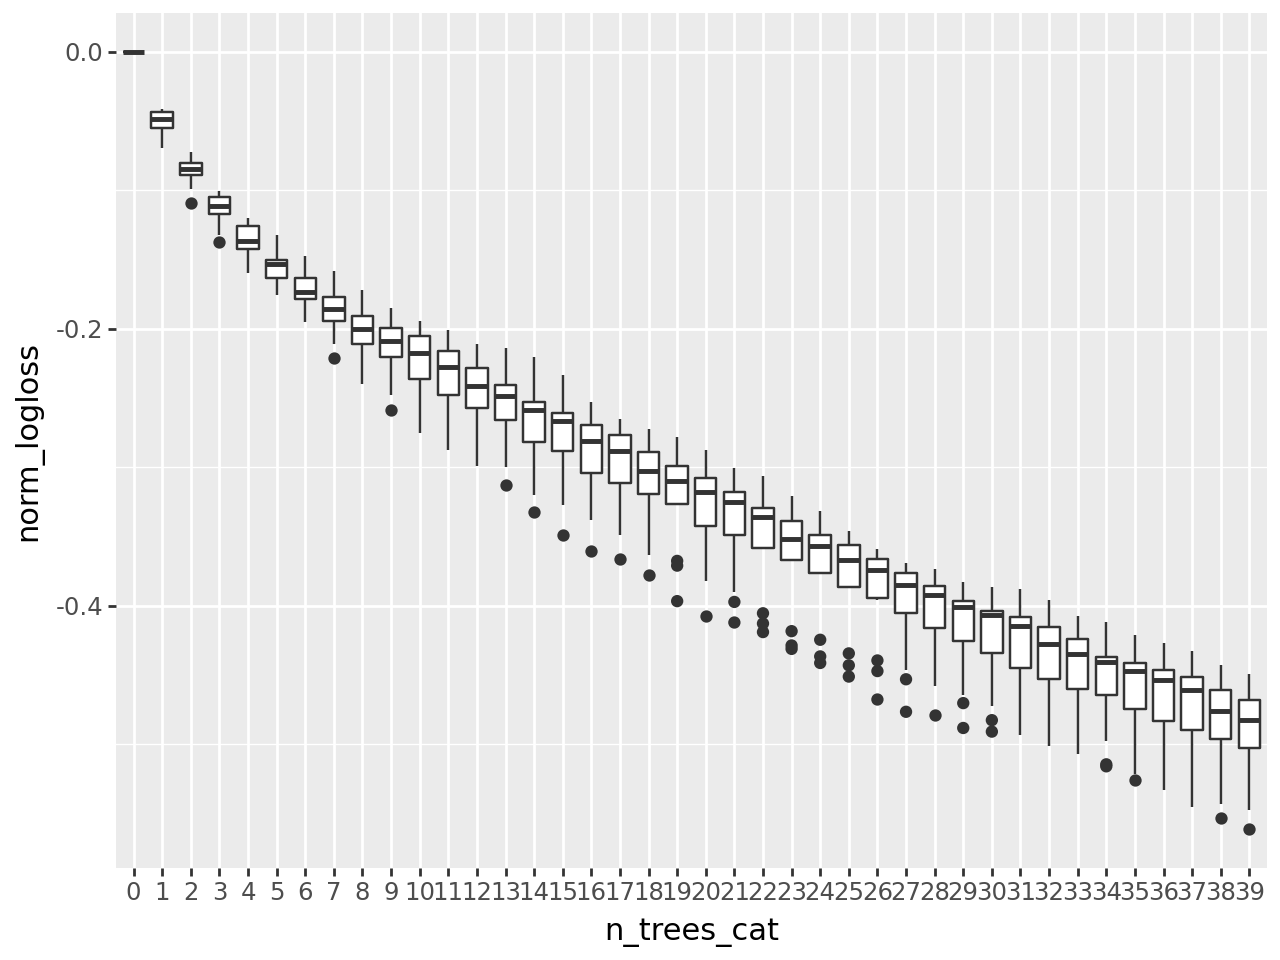

In [61]:
ggplot(train_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

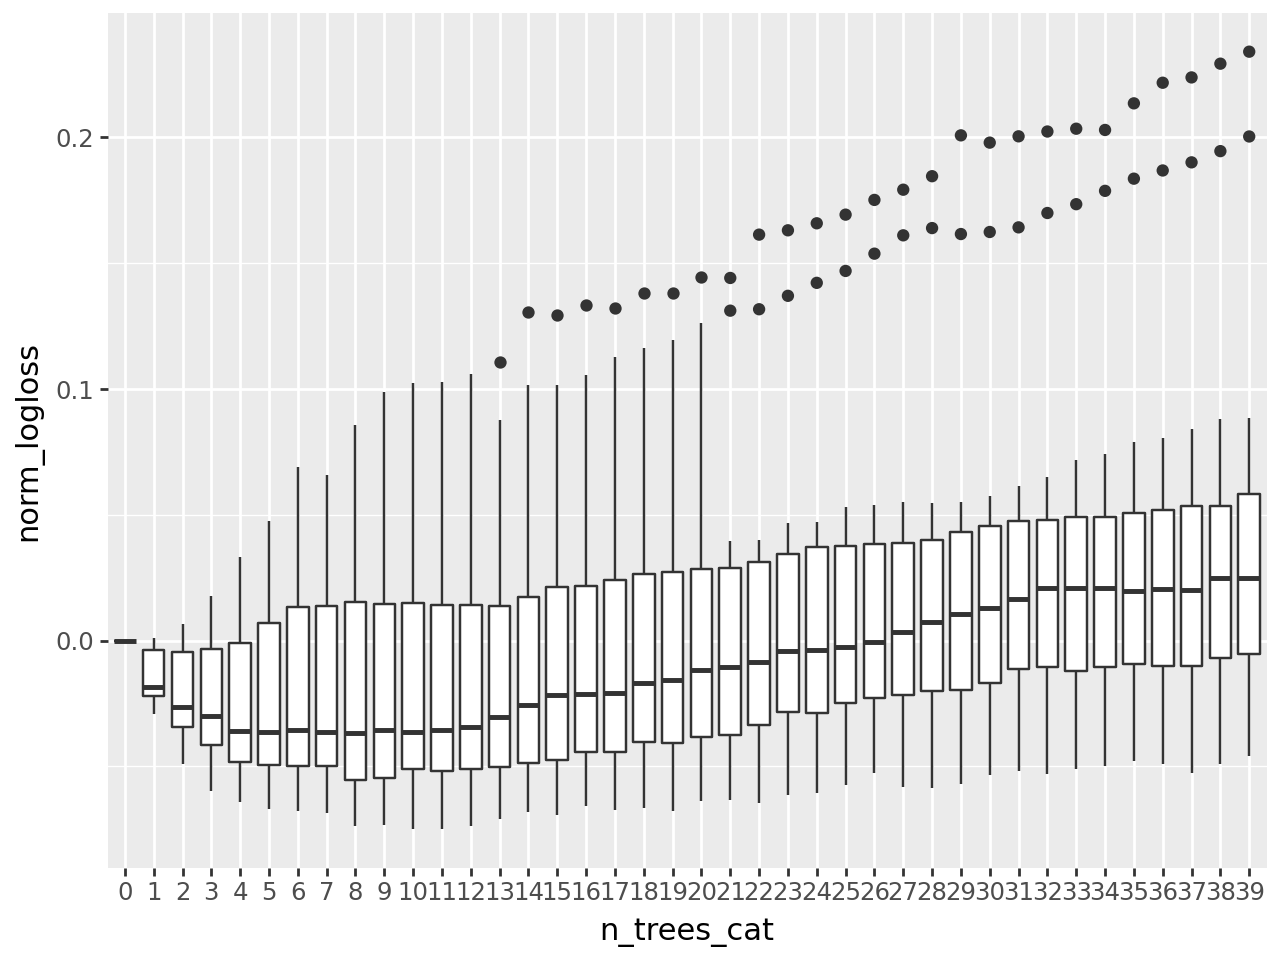

In [62]:
ggplot(test_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

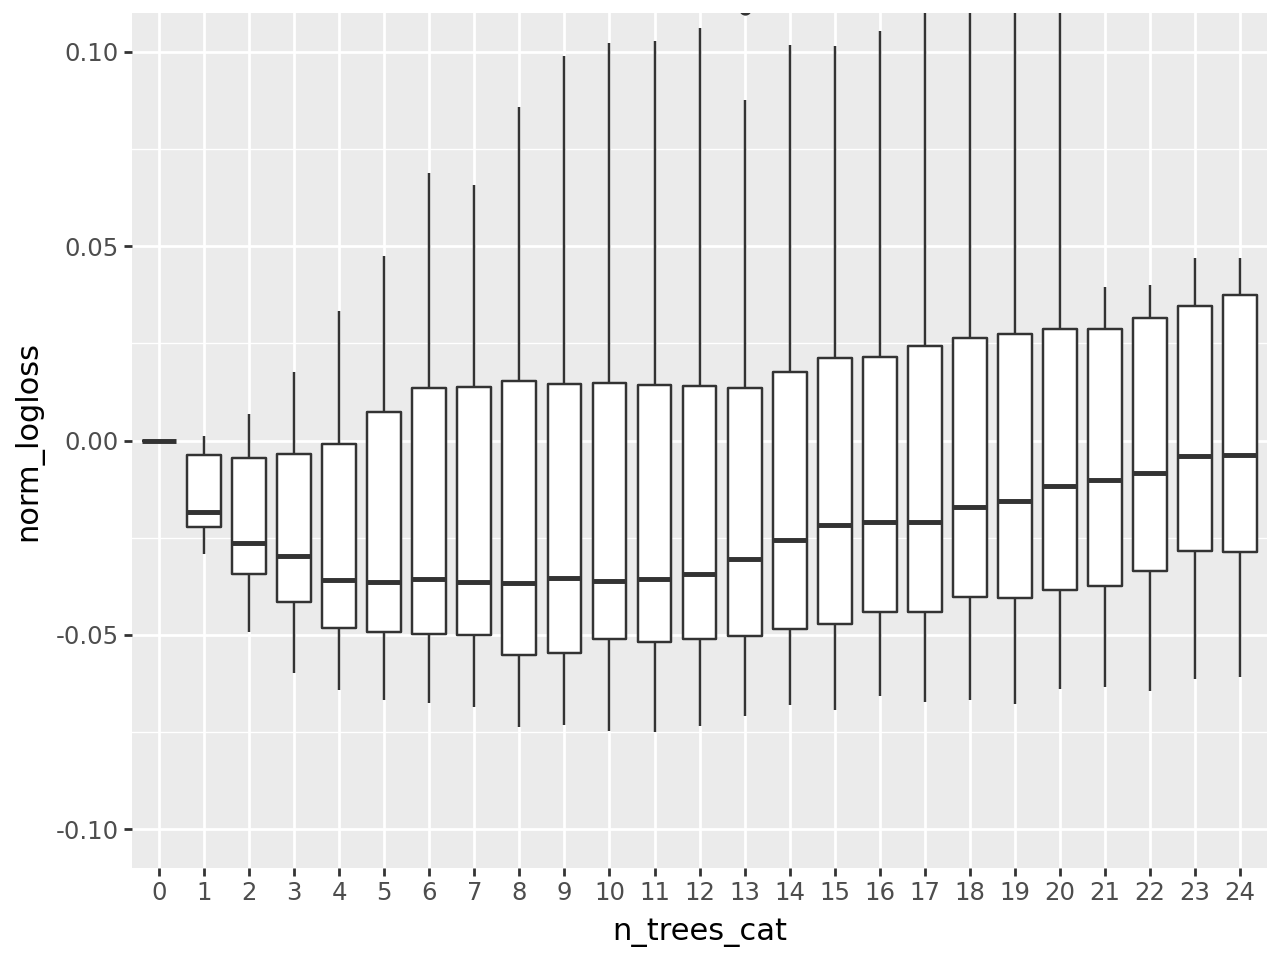

In [63]:
ggplot(test_lc[test_lc["n_trees"] < 25], aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot(outlier_alpha=None) + coord_cartesian(ylim=[-0.1, 0.1])

In [64]:
def train_model(X_train, X_test, n_estimators=300):
    y_train = X_train["churn"]
    y_test = X_test["churn"]

    X_train["month_period"] = X_train["month_period"].astype("category").cat.codes
    X_test["month_period"] = X_test["month_period"].astype("category").cat.codes

    dtrain = xgb.DMatrix(X_train.drop(columns="churn"), label=y_train)
    dtest = xgb.DMatrix(X_test.drop(columns="churn"), label=y_test)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "learning_rate": 0.01,
        "max_depth": 3,
        "min_child_weight": 10,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_alpha": 1.0,
        "reg_lambda": 1.0,
        "nthread": 10,
        "random_state": 1
    }

    evals_result = {}

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=n_estimators,
        evals=[(dtest, "eval"), (dtrain, "train")],
        early_stopping_rounds=20,
        verbose_eval=False,
        evals_result=evals_result
    )

    return model, evals_result, X_train, X_test

In [85]:
train_model_across_periods(n_estimators=90)

2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00


In [86]:
test_lc = return_learning_curve("eval")
train_lc = return_learning_curve("train")

In [87]:
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

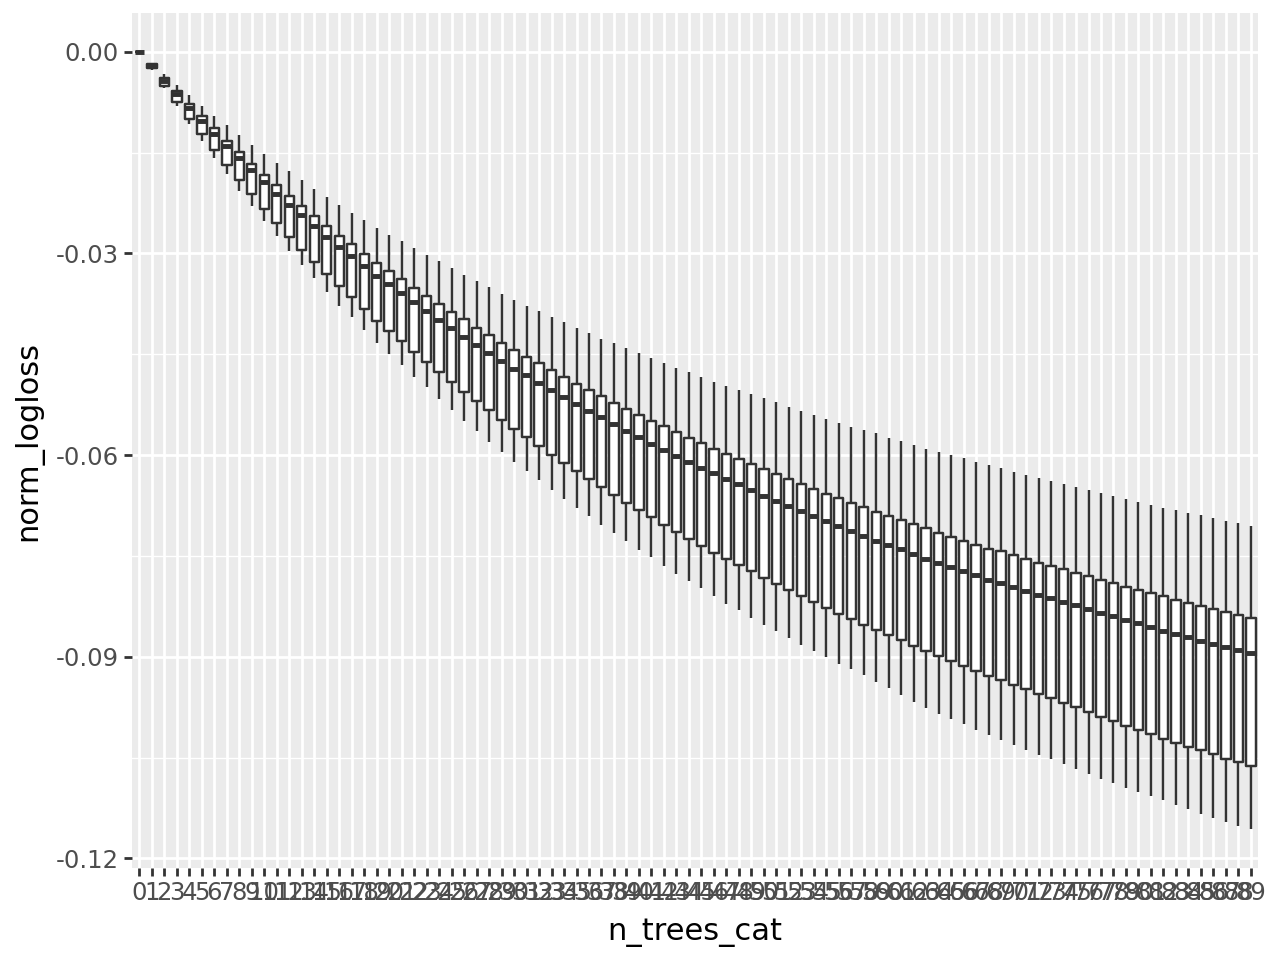

In [88]:
ggplot(train_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

In [ ]:
ggplot(test_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()